In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('penguins.csv')
df.head()

,speciesName,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181,3750
1,Adelie,39.5,17.4,186,3800
2,Adelie,40.3,18.0,195,3250
3,Adelie,36.7,19.3,193,3450
4,Adelie,39.3,20.6,190,3650


In [23]:
df.speciesName.unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

c:\users\ayray\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


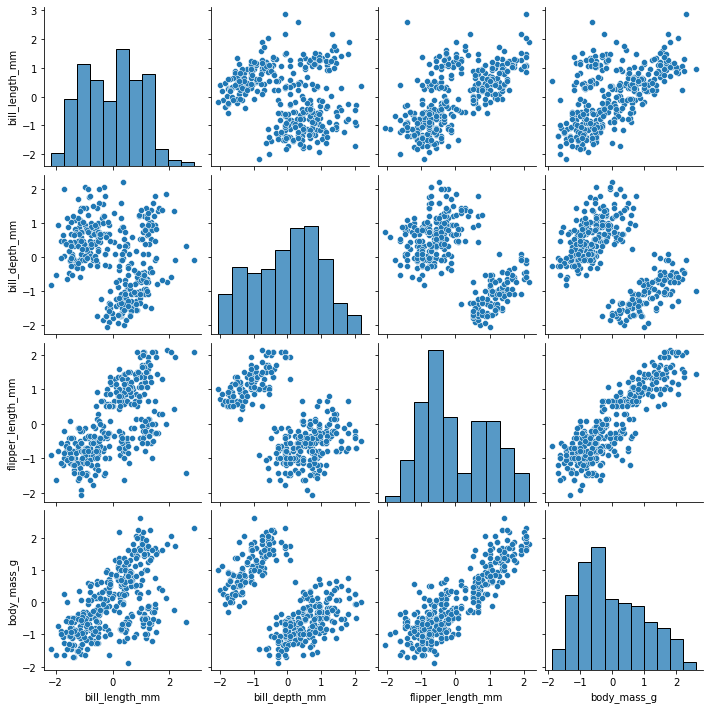

In [24]:
df_new = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]]

for i in df_new.columns:
    df_new[i] = (df_new[i] - df_new[i].mean())/df_new[i].std()
    

sns.pairplot(df_new)

In [27]:
df_new.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.883205,0.784300,-1.416272,-0.563317
1,-0.809939,0.126003,-1.060696,-0.500969
2,-0.663408,0.429833,-0.420660,-1.186793
3,-1.322799,1.088129,-0.562890,-0.937403
4,-0.846572,1.746426,-0.776236,-0.688012


# Fitting K Means

In [28]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, n_init = 25, random_state = 1234)

#fit the kmeans clusters
km = km.fit(df_new)

cluster_centers = pd.DataFrame(km.cluster_centers_,columns=["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"])
display(cluster_centers)

# to get the correct centroids, we need to un-scale the data,

cluster_centers_unscaled = pd.DataFrame()
for i in ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]:
    cluster_centers_unscaled[i] = (cluster_centers[i]*df[i].std()) + df[i].mean()

display(cluster_centers_unscaled)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0.656268,-1.098371,1.157170,1.090164
1,-1.046526,0.485842,-0.889912,-0.769489
2,0.660006,0.815731,-0.285787,-0.373765


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,47.504878,14.982114,217.186992,5076.016260
1,38.208333,18.110606,188.401515,3584.659091
2,47.525287,18.762069,196.896552,3902.011494


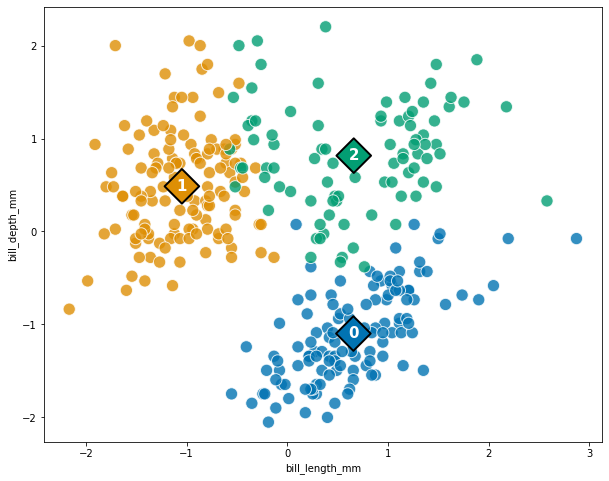

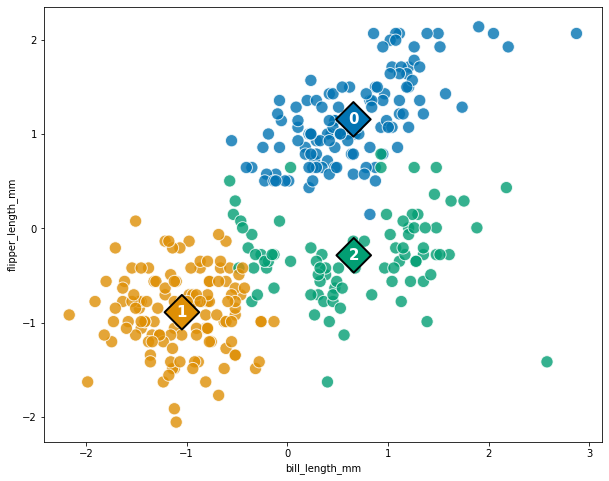

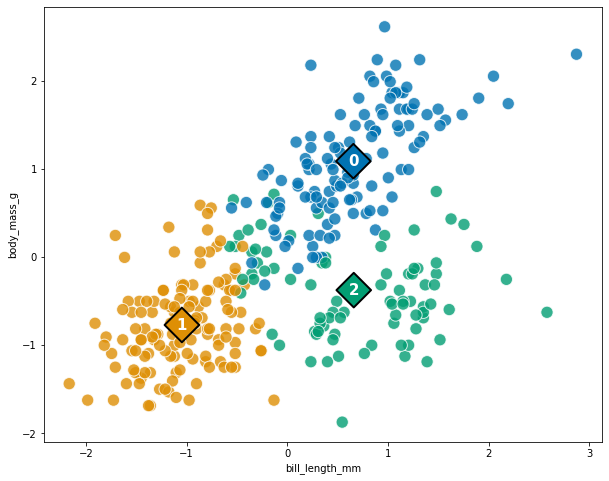

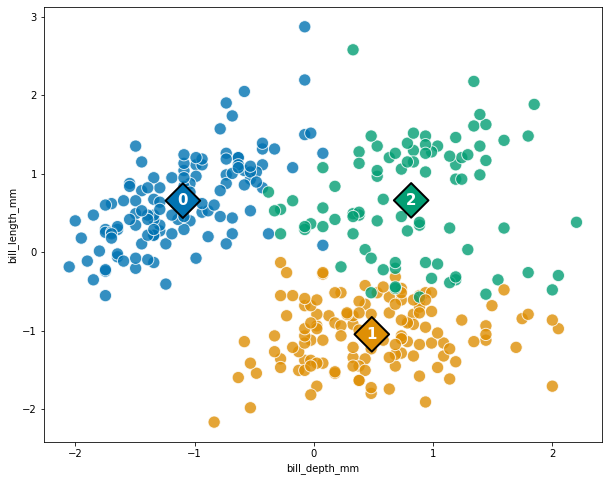

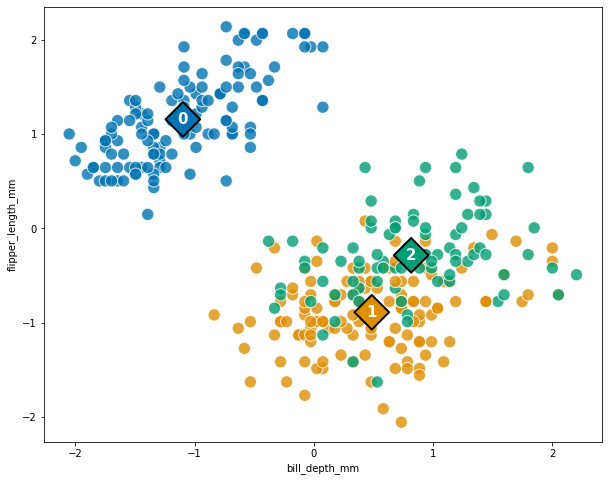

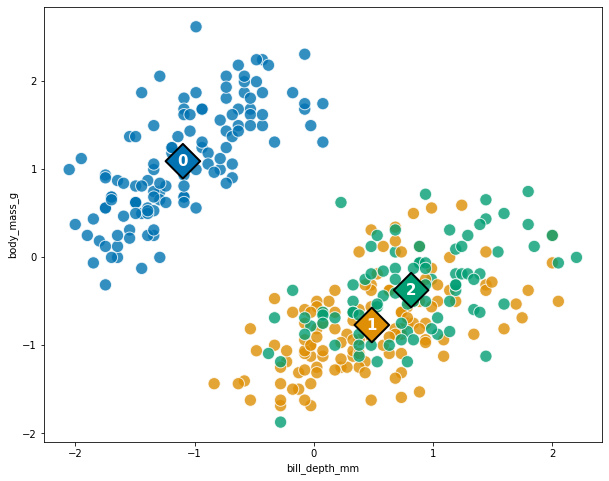

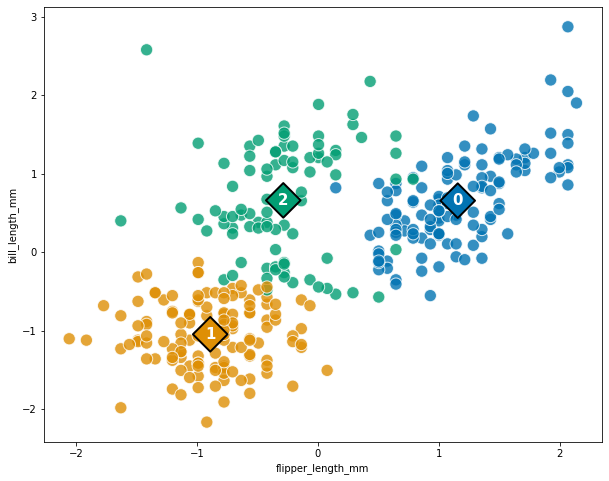

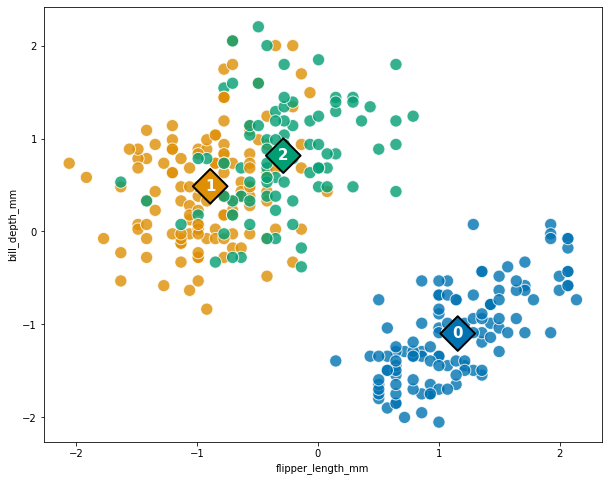

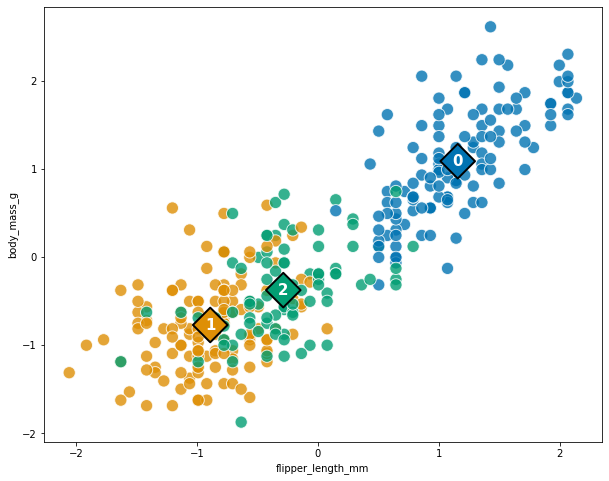

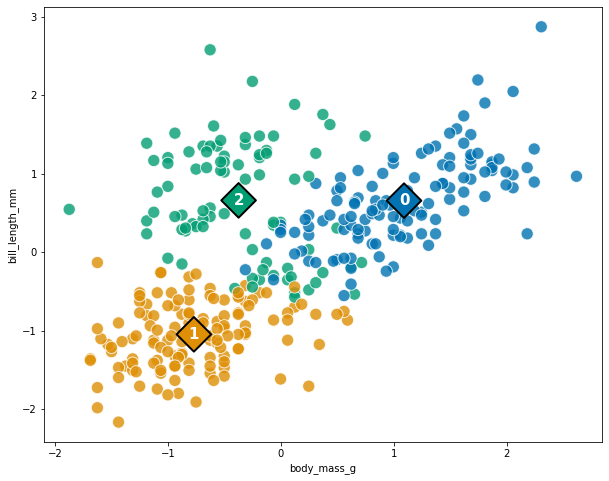

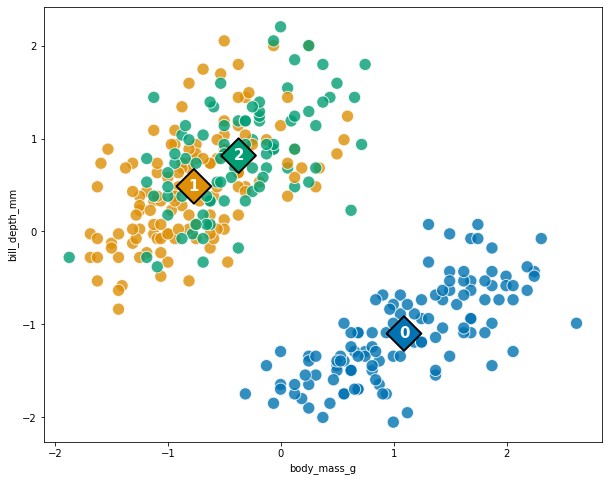

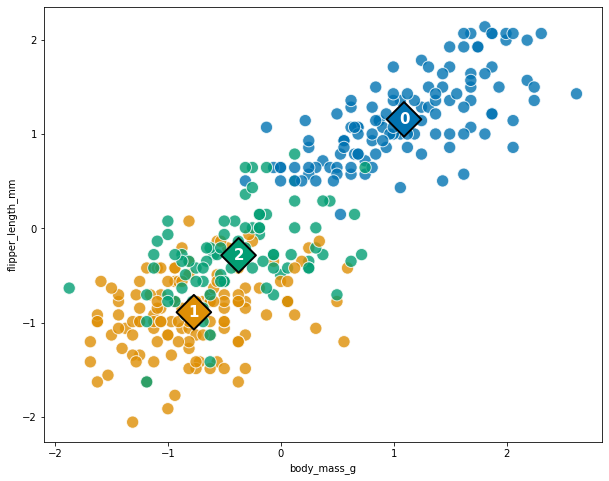

In [29]:
def plot_KMeansClusters(x_axis,y_axis):
    # Set the figure size
    plt.figure(figsize=(10, 8))
    
    #Plot the Clusters
    ax = sns.scatterplot(data = df_new,
                     x = x_axis,
                     y = y_axis, 
                     hue = km.labels_, 
                     palette = 'colorblind', 
                     alpha = 0.8, 
                     s = 150,
                     legend = False)

#Plot the Centroids
    ax = sns.scatterplot(data = cluster_centers, 
                     x = x_axis,
                     y = y_axis, 
                     hue = cluster_centers.index, 
                     palette = 'colorblind', 
                     s = 600,
                     marker = 'D',
                     ec = 'black', 
                     legend = False)

    # Add Centroid Labels
    for i in range(len(cluster_centers)):
               plt.text(x = cluster_centers[x_axis][i], 
                        y = cluster_centers[y_axis][i],
                        s = i, 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 15,
                        weight = 'bold',
                        color = 'white')

for i in df_new.columns:
    for j in df_new.columns:
        if(i!=j):
            plot_KMeansClusters(i,j)
    

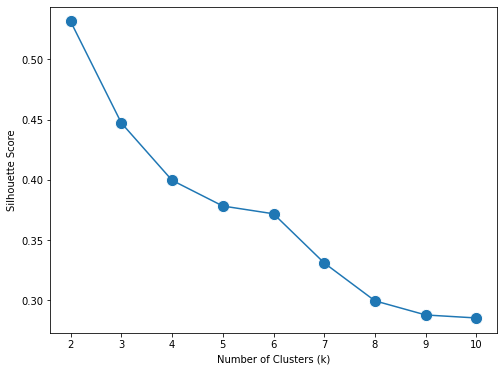

In [30]:
from sklearn.metrics import silhouette_score

ss = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 55)
    km.fit(df_new)
    ss.append(silhouette_score(df_new, km.labels_))

ss_series = pd.Series(ss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = ss_series, x = ss_series.index)
ax = sns.scatterplot(y = ss_series, x = ss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Silhouette Score')

# Fitting DBSCAN

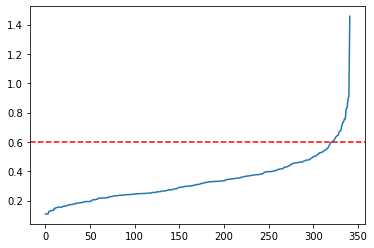

In [31]:
from sklearn.neighbors import NearestNeighbors
# to get the optimal value of eps, use k-nearest neighbour algorithm to find the optimal distance between points
# after which the increase in distance between points becomes steep

k=7
# Fits a NearestNeighbors object to df
nn = NearestNeighbors(n_neighbors=k) \
    .fit(df_new)

dist, ind = nn.kneighbors(df_new)

#sort the distances
dist = np.sort(dist,axis=0)[:,1]

#plot the dist
plt.plot(dist)

#draw a line at the chosen value of eps
plt.axhline(y=0.6, color='r', ls="--")

In [32]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6,min_samples=2).fit(df_new)

clusters = dbscan.labels_
display(pd.DataFrame(clusters).value_counts()/len(df_new)*100)

 0    59.064327
 1    33.918129
-1     5.847953
 2     0.584795
 3     0.584795
dtype: float64

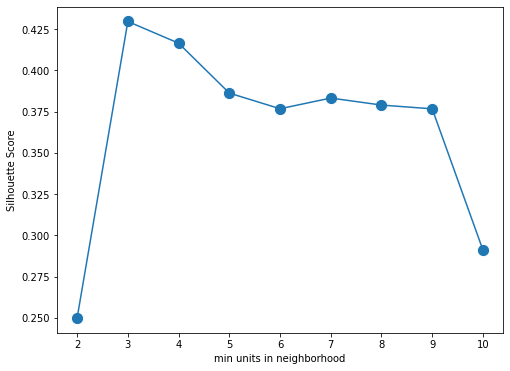

In [33]:
from sklearn.metrics import silhouette_score

ss = []
for k in range(2, 11):
    dbscan = DBSCAN(eps=0.6,min_samples=k)
    dbscan.fit(df_new)
    ss.append(silhouette_score(df_new, dbscan.labels_))

ss_series = pd.Series(ss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = ss_series, x = ss_series.index)
ax = sns.scatterplot(y = ss_series, x = ss_series.index, s = 150)
ax = ax.set(xlabel = 'min units in neighborhood', 
            ylabel = 'Silhouette Score')

#### Using the optimum value of Min pts as 3

In [34]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6,min_samples=3).fit(df_new)

clusters = dbscan.labels_
display(pd.DataFrame(clusters).value_counts()/len(df_new)*100)

 0    59.064327
 1    33.918129
-1     7.017544
dtype: float64

In [35]:
## attaching cluster labels to main data

df['DBSCAN Clusters'] = dbscan.labels_
df_clustered = pd.get_dummies(df)

In [37]:
# cluster statistics

df_clustered.groupby('DBSCAN Clusters').agg({
    'speciesName_Adelie': 'mean',
    'speciesName_Chinstrap': 'mean',
    'speciesName_Gentoo': 'mean',
    'bill_length_mm': 'median',
    'bill_depth_mm': 'median',
    'flipper_length_mm': 'median',
    'body_mass_g':'median'}).round(2)

,speciesName_Adelie,speciesName_Chinstrap,speciesName_Gentoo,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
DBSCAN Clusters,,,,,,,
-1,0.29,0.42,0.29,47.5,17.7,203.5,4350.0
0,0.71,0.29,0.00,40.3,18.4,191.0,3700.0
1,0.00,0.00,1.00,47.2,14.8,216.0,5000.0
